<a href="https://colab.research.google.com/github/sakarla/AI-in-the-Built-Environment/blob/main/week%202_3_DataCollection/Notebook%20code/API_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loop through several URLs**

To work with the Scrapy method with multiple URLs, first, we need to go to the directory that Scrapy located:```drive/MyDrive/Colab Notebooks/myproject```



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/myproject/

/content/drive/MyDrive/Colab Notebooks/myproject


Now open the myspider_text.py located on the `myproject/spiders`.
Then edit the line of code that defines the URL. You can add any URLs to this list.

start_urls = [
  'https://www.archdaily.com/882553/luminous-transparent-mixed-use-tower-will-mark-the-skyline-of-saint-malo?ad_medium=widget&ad_name=category-apartments-article-show',
  'https://www.archdaily.com/1013465/old-rectory-farm-alexander-hills-architects?ad_source=search&ad_medium=projects_tab',
  'https://www.archdaily.com/1015745/old-chapel-jonathan-tuckey-design?ad_source=search&ad_medium=projects_tab'
]

Now you can download the text from several URLs and save it in the JSON file.


In [ ]:
!pip install scrapy
import scrapy
'''This command is used to run a Scrapy spider named "my_spider" within the "myproject" Scrapy project
and save the scraped data to an output JSON file named "output_text.json."'''

#This line collects text

##################################################
!cd myproject && scrapy crawl my_spider_text -o output_text_all.json
##################################################

In [ ]:
#This line collects images

##################################################
!cd myproject && scrapy crawl my_spider_img -o output_img_all.json
##################################################

# **Data colection with API**

In this notebook, you will learn how to collect data from the Internet using API.

We will work with **Google API** to collect satellite images and street view images.


**What is API?**

An API (Application Programming Interface) is like a bridge that allows two different software applications to communicate with each other.

**Why Use an API?**

APIs are useful because they allow you to access the functionality or data of other software systems in a structured way. This means you can leverage powerful services and data without having to build everything from scratch.

To do this you need to learn how to get the API key.

# **Detailed Guide to Set Up Google Street View Static API**
To download Street View images using the Google Street View Static API, follow these steps:

1. Go to **Google Cloud Console**:
Open your web browser and navigate to Google Cloud Console.
 https://cloud.google.com/cloud-console?utm_source=google&utm_medium=cpc&utm_campaign=na-US-all-en-dr-bkws-all-all-trial-e-dr-1707554&utm_content=text-ad-none-any-DEV_c-CRE_665735422256-ADGP_Hybrid%20%7C%20BKWS%20-%20MIX%20%7C%20Txt-Management%20Tools-Cloud%20Console-KWID_43700077225654741-aud-2232802565252%3Akwd-55675752867&utm_term=KW_google%20cloud%20console-ST_google%20cloud%20console&gad_source=1&gclid=Cj0KCQjw3tCyBhDBARIsAEY0XNm9MwHvCMYuhE2lFAk1xQgRLngbGtHHKRWNtBNJ9OkGRkYXX9cK9S4aAhXMEALw_wcB&gclsrc=aw.ds .


2. **Create a New Project:**

    In the top navigation bar, click on the **project** drop-down.
    Click on "**New Project**".
    Enter the project name and billing account if prompted.
    Click "**Create**".

3. **Enable the Street View Static API:**

    In the left-hand menu, navigate to APIs & Services > Library.
    In the search bar, type Street View Static API.
    Click on Street View Static API from the search results.
    Click on the Enable button.

4. **Generate an API Key:**

    After enabling the API, navigate to APIs & Services > Credentials from the left-hand menu.
    Click on + CREATE CREDENTIALS at the top.
    Select API key from the drop-down menu.
    An API key will be generated. Copy this key as you will need it for your Python script.
    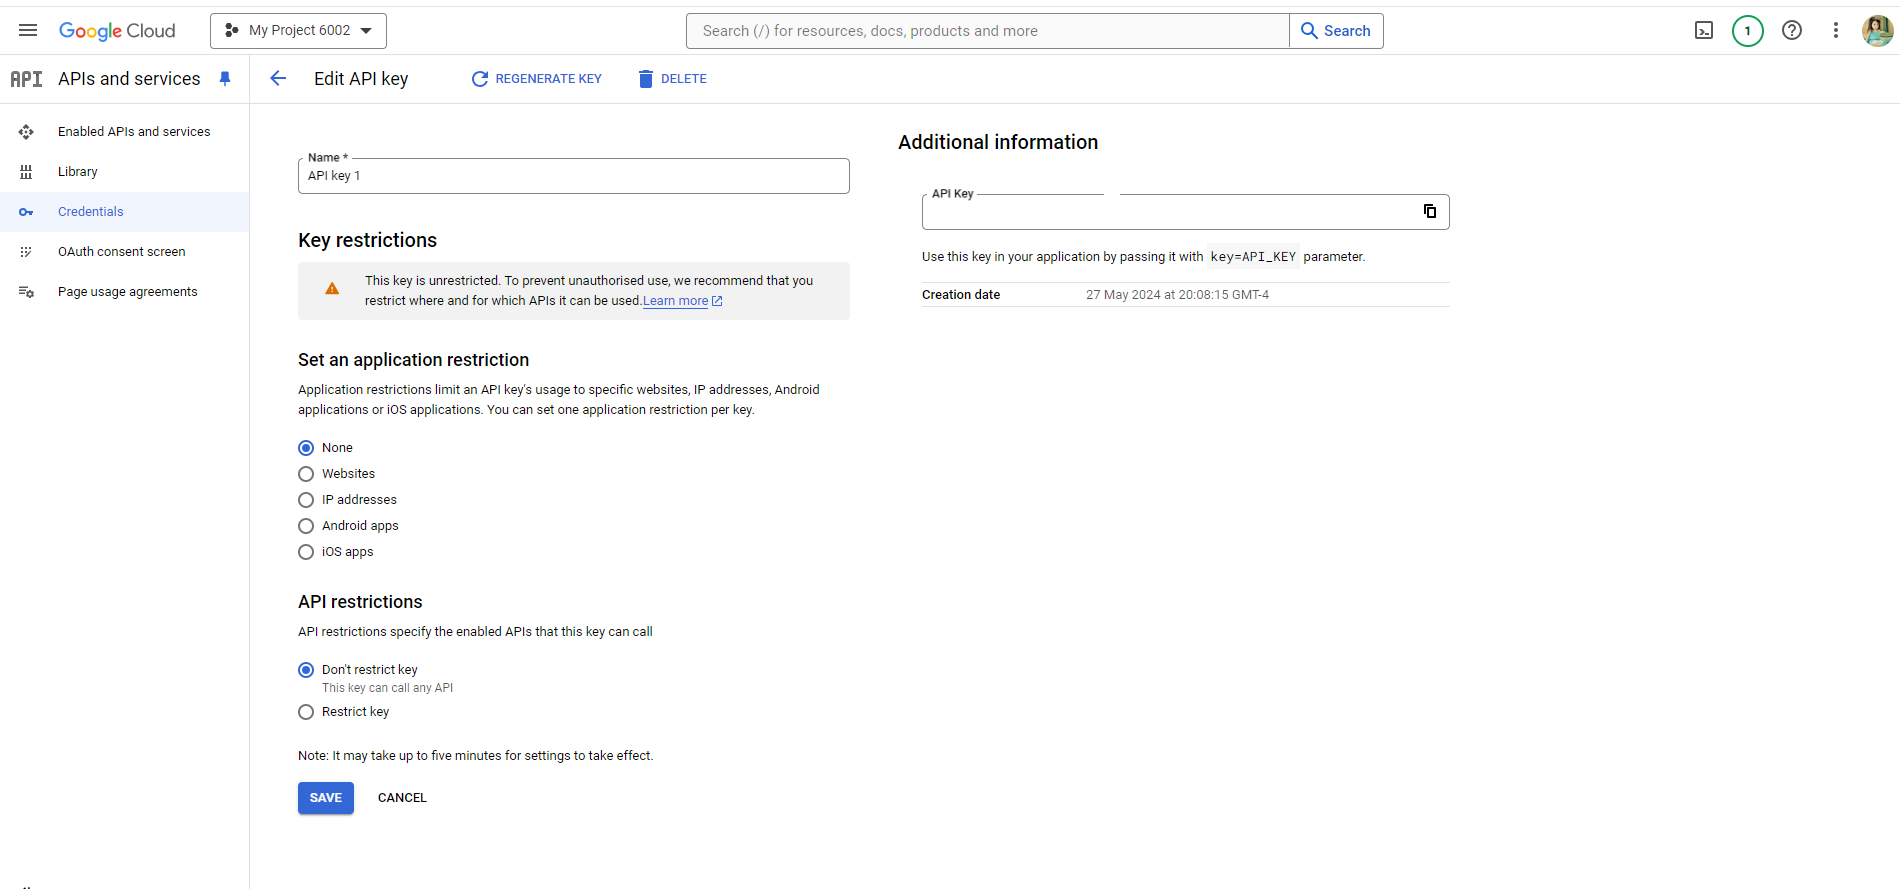

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_streetview_image(api_key, location, size="600x300", heading=0, pitch=0, fov=90):
    streetview_url = "https://maps.googleapis.com/maps/api/streetview"
    params = {
        "size": size,
        "location": location,
        "heading": heading,
        "pitch": pitch,
        "fov": fov,
        "key": api_key
    }

    response = requests.get(streetview_url, params=params)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        img.save('streetview_image.jpg')
        print("Image downloaded and saved as 'streetview_image.jpg'")
    else:
        print(f"Error: {response.status_code}, {response.text}")

# Replace with your own values
api_key = "YOUR_API_KEY"
location = "40.689247,-74.044502"  # Latitude, Longitude for the Statue of Liberty

download_streetview_image(api_key, location)


Error: 403, The Google Maps Platform server rejected your request. The provided API key is invalid. 


# **Set Up Google Maps Static API:**
To download satellite images from Google, you typically use the Google Maps Static API. This API allows you to get static maps, including satellite imagery, at various zoom levels and locations.

1. Go to the Google Cloud Console.
2. Create a new project if you don't have one.
3. Enable the Maps Static API for your project.
4. Generate an API key.

# **Collecting several street view images**

Since we want to collect more than one street view image we have to write code to get a list of coordinates.

**Calculating a Regular Grid**

  A regular grid does not equal a regular grid across projections. You are talking about latitude/longitude pairs, which is a polar coordinate system measured in degrees on an approximation of Earth's surface shape. In lat/lon (EPSG:4326), distances are not measured in meters/kilometers/miles, but rather in degrees.

  We will generate a grid spaced in meters, for that you need to project your lat/lon boundaries of your input area (your certain area on a map) into a coordinate system that supports distances in meters. We will use the Haversine formula as a rough approximation to calculate the distance between lat/lon pairs, but this is not the best method you can use.

  In this case we are going to get the bounding box coordinates from Google Maps that use EPSG:900913 projection for their web mapping service.

In [6]:
!pip install shapely

import shapely.geometry
import pyproj

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857')
to_original_transformer = pyproj.Transformer.from_crs('epsg:3857', 'epsg:4326')

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((-81.434734, 28.466189))
ne = shapely.geometry.Point((-81.412675, 28.484533))

stepsize = 1000 # 1 km (1000 m) grid step size

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

with open('/content/drive/MyDrive/Colab Notebooks/testout.csv', 'w') as of:
    of.write('lat;lon\n')
    for p in gridpoints:
        of.write('{:f};{:f}\n'.format(p.y, p.x))

In [10]:
import pandas as pd

# Load and inspect the CSV file

##################################################
file_path = "/content/drive/My Drive/Colab Notebooks/testout.csv"  # Replace with the correct path to your CSV file
api_key = "Your_API_KEY"
##################################################

# Read the CSV file without specifying a delimiter
coords= pd.read_csv(file_path)

  # Ensure the 'lat;lon' column is treated as strings
coords['lat;lon'] = coords['lat;lon'].astype(str)

    # Transform the coordinates into comma-separated strings
coords['lat;lon'] = coords['lat;lon'].str.replace(';', ',')

locations= coords['lat;lon'].tolist()

In [12]:
import os
import requests
from PIL import Image
from io import BytesIO

def download_satellite_image(api_key, location, folder_name, zoom=18, size="600x600", maptype="satellite"):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    maps_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": location,
        "zoom": zoom,
        "size": size,
        "maptype": maptype,
        "key": api_key
    }

    response = requests.get(maps_url, params=params)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        if img.mode == 'P':  # Check if the image is palette-based
            img = img.convert('RGB')  # Convert to RGB mode
        location_str = location.replace(',', '_').replace(' ', '')  # Format location string for filename
        img.save(os.path.join(folder_name, f'{location_str}.jpg'))
        print(f"Image downloaded and saved as '{os.path.join(folder_name, location_str)}.jpg'")
    else:
        print(f"Error: {response.status_code}, {response.text}")

# Replace with your own values
api_key = "YOUR_API_KEY"

folder_name = "satellite_images"  # Folder to save images

for location in locations:
    download_satellite_image(api_key, location, folder_name)


Image downloaded and saved as 'satellite_images/28.466189_-81.434734.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.433396.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.432058.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.430719.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.429381.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.428042.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.426703.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.425364.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.424024.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.422684.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.421344.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.420004.jpg'
Image downloaded and saved as 'satellite_images/28.466189_-81.418664.jpg'
Image downloaded and saved as 'satelli